In [ ]:
!pip install transformers scikit-learn torch pandas --quiet

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [ ]:
#load dataset
df = pd.read_excel('hate_sample_for_finetune.xlsx')
df = df.dropna(subset=['hate_type_teacher'])

In [ ]:
# --- Balance classes ---
df_majority = df[df['hate_type_teacher'] == 'sarcasm-based hate']
df_minority = df[df['hate_type_teacher'] != 'sarcasm-based hate']

# Oversample minority classes to match majority count
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

In [ ]:
# Combine and shuffle
#making df_balanced
df_balanced = pd.concat([df_majority, df_minority_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced['hate_type_teacher'].value_counts())

hate_type_teacher
sarcasm-based hate        1267
metaphor-based hate        530
meme-language hate         321
humor-based hate           221
political framing hate     195
Name: count, dtype: int64


In [ ]:
#encode labels
label_mapping = {label: idx for idx, label in enumerate(df['hate_type_teacher'].unique())}
df_balanced['hate_type_teacher_int'] = df_balanced['hate_type_teacher'].map(label_mapping)
print("Label mapping:", label_mapping)

Label mapping: {'political framing hate': 0, 'sarcasm-based hate': 1, 'meme-language hate': 2, 'humor-based hate': 3, 'metaphor-based hate': 4}


In [ ]:
df_balanced.head()

,orig_index,label,text,clean_text,hate_type,hate_type_teacher,teacher_score,hate_type_teacher_int
0,370465,1,@lauracdean I love how the Islamofascists recr...,lauracdeanilovehowtheislamofascistsrecruitandy...,NaN,metaphor-based hate,0.384004,4
1,660478,1,before calling others stupid you gay piece of ...,beforecallingothersstupidyougaypieceofshityous...,NaN,metaphor-based hate,0.360810,4
2,724158,1,That nigga is fucking trash,thatniggaisfuckingtrash,NaN,sarcasm-based hate,0.488203,1
3,617192,1,Most women are too easily swayed by emotional ...,mostwomenaretooeasilyswayedbyemotionalpleastov...,NaN,metaphor-based hate,0.431158,4
4,470725,1,Or what your gonna ban my IP? What a joke... D...,orwhatyourgonnabanmyipwhatajokedumbass,NaN,sarcasm-based hate,0.519237,1


In [ ]:
#split into train test
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_balanced['clean_text'], df_balanced['hate_type_teacher_int'], test_size=0.2, random_state=42,stratify=df_balanced['hate_type_teacher']
)

In [ ]:
#tokenization
model_name = "google/mobilebert-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping))

config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/147M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/147M [00:00<?, ?B/s]

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#tokenize train and validation data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)

In [ ]:

class HateSpeechDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.reset_index(drop=True)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels.iloc[idx]), dtype=torch.long)
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = HateSpeechDataset(train_encodings, train_labels)
val_dataset = HateSpeechDataset(val_encodings, val_labels)

In [ ]:
# --- Metrics Function ---
def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = preds.argmax(axis=1)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': prec, 'recall': rec}


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    report_to=[]

)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [ ]:
trainer.train()
metrics = trainer.evaluate()
print(metrics)

Step,Training Loss
500,1.118500


{'eval_loss': 1.0540534257888794, 'eval_runtime': 5.3531, 'eval_samples_per_second': 94.712, 'eval_steps_per_second': 5.978, 'epoch': 5.0}


In [ ]:
#save model
model.save_pretrained('./my_mobilebert_model')
tokenizer.save_pretrained('./my_mobilebert_model')

('./my_mobilebert_model/tokenizer_config.json',
 './my_mobilebert_model/special_tokens_map.json',
 './my_mobilebert_model/vocab.txt',
 './my_mobilebert_model/added_tokens.json',
 './my_mobilebert_model/tokenizer.json')

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Run predictions on validation dataset
predictions = trainer.predict(val_dataset)

# Get predicted class labels
pred_labels = predictions.predictions.argmax(axis=1)

# True labels
true_labels = predictions.label_ids

# Calculate and print accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Print full classification report with precision, recall, F1-score per class
report = classification_report(true_labels, pred_labels)
print("Classification Report:\n", report)


Accuracy: 0.6331
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.21      0.30        39
           1       0.60      0.91      0.73       254
           2       0.74      0.53      0.62        64
           3       0.91      0.45      0.61        44
           4       0.67      0.26      0.38       106

    accuracy                           0.63       507
   macro avg       0.70      0.47      0.53       507
weighted avg       0.66      0.63      0.60       507



In [ ]:
y_true = val_labels

/tmp/ipython-input-1059269796.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=f1_scores, palette='viridis')


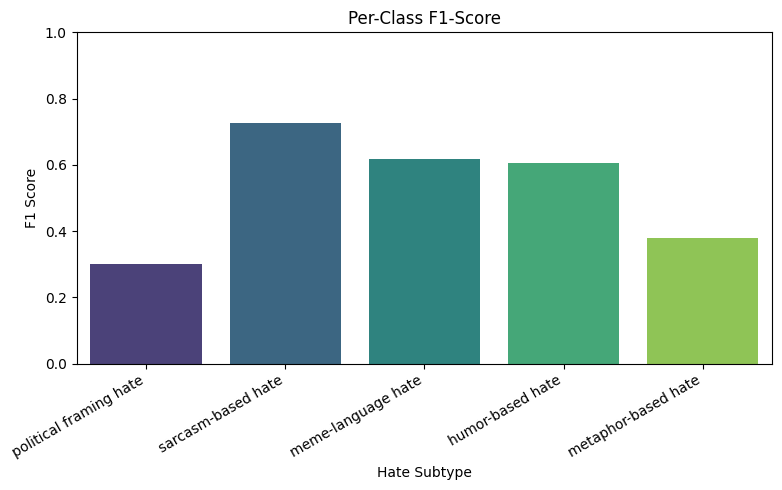

In [ ]:
#  Per-Class F1 Scores
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

labels = list(label_mapping.keys())
f1_scores = f1_score(true_labels, pred_labels, average=None)
plt.figure(figsize=(8,5))
sns.barplot(x=labels, y=f1_scores, palette='viridis')
plt.xticks(rotation=30, ha='right')
plt.title('Per-Class F1-Score')
plt.ylabel('F1 Score')
plt.xlabel('Hate Subtype')
plt.ylim(0,1)
plt.tight_layout()
plt.show()

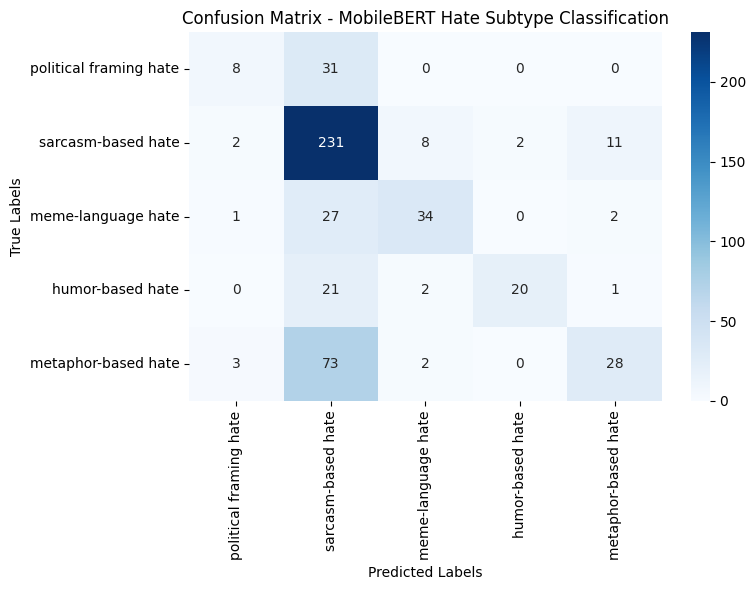

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - MobileBERT Hate Subtype Classification')
plt.tight_layout()
plt.show()